# ENTRENAMIENTO DE RED NEURONAL

### Importación de Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Estructura del Pipeline

In [2]:
apple_df = pd.read_csv("AAPL.csv")
apple_df_2025 = pd.read_csv("AAPL_historical_data.csv")
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
apple_df.set_index('Date', inplace=True)
print(apple_df.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099319  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094137  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087228  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089387   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091978   73449600


### Preprocesamiento de Datos

In [3]:
scaler = MinMaxScaler()
apple_df_scaled = scaler.fit_transform(apple_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Crear secuencias con múltiples características
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length])  # Ventana deslizante
        targets.append(
            data[i + sequence_length, 4]
        )  # El índice 4 corresponde a 'Adj Close' (columna objetivo)
    return np.array(sequences), np.array(targets)

sequence_lenght = 30
X, y = create_sequences (apple_df_scaled, sequence_lenght)

# División de Conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [4]:
# Convertir y_test (tensores de PyTorch) a un numpy array
y_test_numpy = y_test.numpy()

# Desnormalizar y_test utilizando el scaler
# NOTA: Concatenamos ceros porque solo queremos desnormalizar 'Adj Close'
y_test_original = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_test_numpy.shape[0], 5)), y_test_numpy.reshape(-1, 1)), axis=1
    )
)[
    :, 5
]  # Solo tomamos la columna de 'Adj Close'

# Extraer las fechas correspondientes al conjunto de prueba
fechas = apple_df.index[
    -len(y_test_original) :
]  # Asume que las fechas están alineadas con el conjunto de prueba

### Definición de Modelo (clase con funciones)

In [ ]:
# Modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predecimos una sola salida (Adj Close)

    def forward(self, x):
        out, _ = self.lstm(x)  # x: [batch_size, sequence_length, input_size]
        out = self.fc(out[:, -1, :])  # Tomamos el último paso temporal
        return out

# Instanciar el modelo
model = LSTMModel(input_size=6, hidden_size=50, num_layers=2)
model.lstm = nn.LSTM(6, 50, 2, batch_first=True, dropout=0.3)

### Entrenamiento de Modelo

In [6]:
# Configuración del optimizador y la función de pérdida
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # Reiniciar los gradientes
    predictions = model(X_train)  # Predicciones en el conjunto de entrenamiento
    loss = loss_function(
        predictions.flatten(), y_train
    )  # Comparar con los valores reales
    loss.backward()  # Retropropagación
    optimizer.step()  # Actualizar los pesos del modelo

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0486
Epoch 2/50, Loss: 0.0460
Epoch 3/50, Loss: 0.0441
Epoch 4/50, Loss: 0.0426
Epoch 5/50, Loss: 0.0411
Epoch 6/50, Loss: 0.0400
Epoch 7/50, Loss: 0.0389
Epoch 8/50, Loss: 0.0374
Epoch 9/50, Loss: 0.0359
Epoch 10/50, Loss: 0.0343
Epoch 11/50, Loss: 0.0326
Epoch 12/50, Loss: 0.0307
Epoch 13/50, Loss: 0.0286
Epoch 14/50, Loss: 0.0266
Epoch 15/50, Loss: 0.0240
Epoch 16/50, Loss: 0.0213
Epoch 17/50, Loss: 0.0183
Epoch 18/50, Loss: 0.0150
Epoch 19/50, Loss: 0.0114
Epoch 20/50, Loss: 0.0080
Epoch 21/50, Loss: 0.0045
Epoch 22/50, Loss: 0.0021
Epoch 23/50, Loss: 0.0007
Epoch 24/50, Loss: 0.0015
Epoch 25/50, Loss: 0.0042
Epoch 26/50, Loss: 0.0059
Epoch 27/50, Loss: 0.0056
Epoch 28/50, Loss: 0.0046
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0017
Epoch 31/50, Loss: 0.0010
Epoch 32/50, Loss: 0.0008
Epoch 33/50, Loss: 0.0009
Epoch 34/50, Loss: 0.0011
Epoch 35/50, Loss: 0.0015
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0020
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.

### Evaluación de Modelo

In [7]:
# Evaluar el modelo
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], 5)), predictions), axis=1)
)[:, 5]

# Desnormalizar y_test
y_test_numpy = y_test.numpy()
y_test_original = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_test_numpy.shape[0], 5)), y_test_numpy.reshape(-1, 1)), axis=1
    )
)[:, 5]


In [8]:
# Calculo de Error Absoluto Medio (MAE)
mae = np.mean(np.abs(predictions - y_test_original))
print(f"MAE: {mae:.4f}")

# Calculo de Error Cuadratico Medio (MSE)
mse = np.mean((predictions - y_test_original) ** 2)
print(f"MSE: {mse:.4f}")

# Calculo de coeficiente de determinación (R^2)
ss_total = np.sum((y_test_original - np.mean(y_test_original)) ** 2)
ss_residual = np.sum((y_test_original - predictions) ** 2)
r2 = 1 - (ss_residual / ss_total)
print(f"R^2: {r2:.4f}")

# Calcular el RMSE
rmse = np.sqrt(np.mean((predictions - y_test_original) ** 2))
print(f"RMSE: {rmse:.4f}")

# Calcular el MAPE
mape = np.mean(np.abs((predictions - y_test_original) / y_test_original)) * 100
print(f"MAPE: {mape:.2f}%")

MAE: 110102744.2367
MSE: 31594317045465016.0000
R^2: 0.9871
RMSE: 177747903.0691
MAPE: 795.07%


### Dataframe Post-Entrenamiento para Comparativa

In [9]:
# Crear un DataFrame para manejar las fechas, valores reales y predicciones
df_resultados = pd.DataFrame(
    {"Fecha": fechas, "Real": y_test_original, "Predicción": predictions.flatten()}
)

# Filtrar las filas al final de cada año
df_resultados["Fecha"] = pd.to_datetime(
    df_resultados["Fecha"]
)  # Asegurar que sea datetime
fin_de_año = df_resultados.groupby(df_resultados["Fecha"].dt.year).tail(1)

print(fin_de_año)

          Fecha          Real    Predicción
240  2011-12-30  2.012367e+06 -4.554494e+07
490  2012-12-31  3.327538e+06 -5.103457e+07
742  2013-12-31  3.327538e+06 -3.880397e+07
994  2014-12-31  5.437986e+09  5.826408e+09
1246 2015-12-31  5.657672e+08  6.192874e+08
1498 2016-12-30  1.701504e+06 -4.588125e+07
1749 2017-12-29  1.244012e+09  1.451416e+09
2000 2018-12-31  1.452456e+09  1.641661e+09
2252 2019-12-31  5.657359e+06 -4.084316e+07
2505 2020-12-31  1.227845e+07 -4.219514e+07
2757 2021-12-31  1.390642e+06 -4.521416e+07
3008 2022-12-30  1.019280e+08 -1.074862e+07
3241 2023-12-05  5.603598e+06 -4.473309e+07


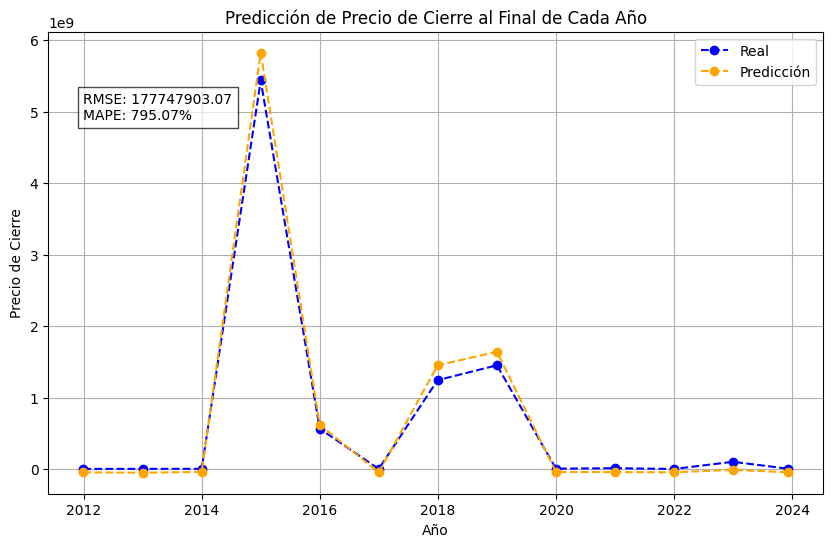

In [10]:
# Crear la gráfica
plt.figure(figsize=(10, 6))

# Añadir las líneas de valores reales y predicciones
plt.plot(
    fin_de_año["Fecha"],
    fin_de_año["Real"],
    marker="o",
    label="Real",
    color="blue",
    linestyle="--",
)
plt.plot(
    fin_de_año["Fecha"],
    fin_de_año["Predicción"],
    marker="o",
    label="Predicción",
    color="orange",
    linestyle="--",
)

# Añadir RMSE y MAPE como texto en la gráfica
plt.text(
    fin_de_año["Fecha"].iloc[0],  # Posición en el eje X
    max(fin_de_año["Real"])
    * 0.9,  # Posición en el eje Y (ajusta el 0.9 según tu gráfico)
    f"RMSE: {rmse:.2f}\nMAPE: {mape:.2f}%",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7),
)  # Fondo blanco para que sea legible

# Personalizar la gráfica
plt.title("Predicción de Precio de Cierre al Final de Cada Año")
plt.xlabel("Año")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

### Calculo de Errores de Predicciones

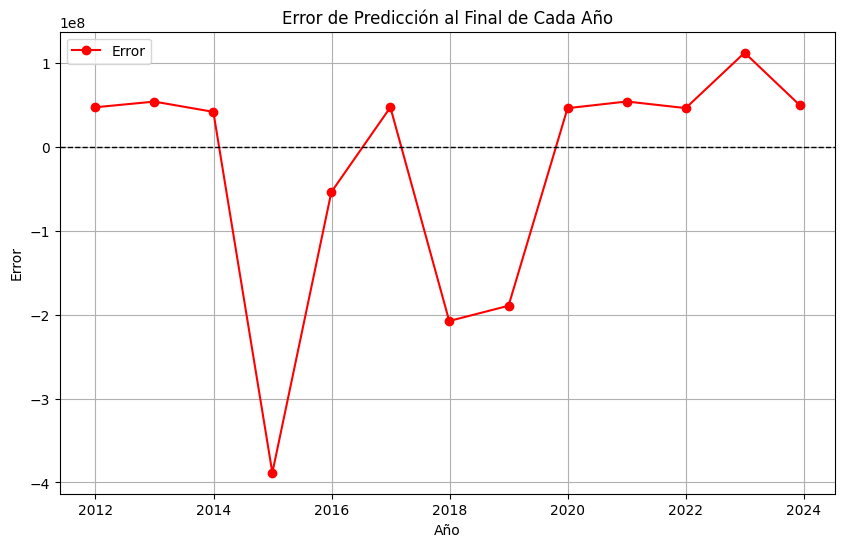

In [11]:
error = fin_de_año["Real"] - fin_de_año["Predicción"]
plt.figure(figsize=(10, 6))
plt.plot(fin_de_año["Fecha"], error, marker="o", label="Error", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Error de Predicción al Final de Cada Año")
plt.xlabel("Año")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.show()

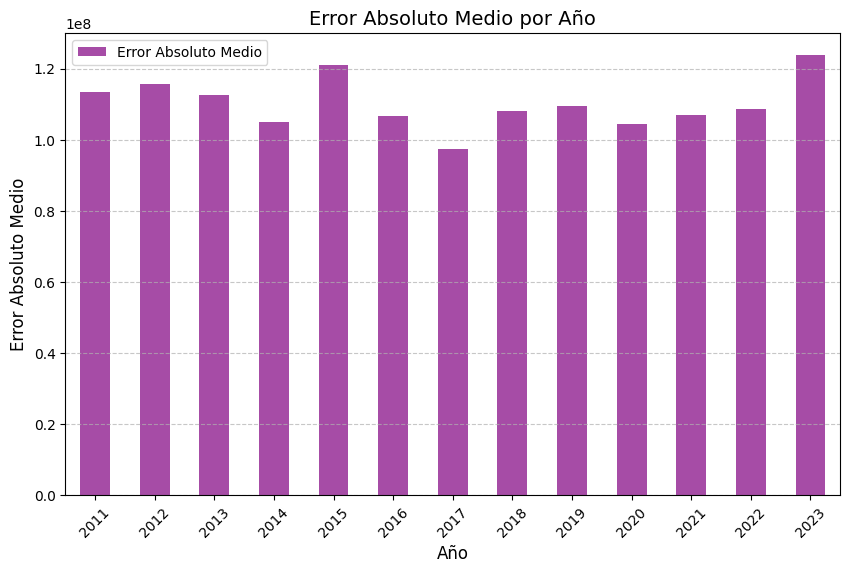

In [12]:
# Calcular errores anuales
df_resultados["Error Absoluto"] = np.abs(
    df_resultados["Real"] - df_resultados["Predicción"]
)
errores_anuales = df_resultados.groupby(df_resultados["Fecha"].dt.year)[
    "Error Absoluto"
].mean()

# Crear una gráfica para mostrar el error por año
plt.figure(figsize=(10, 6))

# Añadir los errores anuales como barras
errores_anuales.plot(
    kind="bar", color="purple", alpha=0.7, label="Error Absoluto Medio"
)

# Personalizar la gráfica
plt.title("Error Absoluto Medio por Año", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Error Absoluto Medio", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.legend()

# Mostrar la gráfica
plt.show()